**<center>CSC12110 – Phân tích dữ liệu ứng dụng<br>ĐỒ ÁN THỰC HÀNH #1</center>**

# **Thông tin nhóm**
|MSSV|Tên thành viên|Công việc|Phần trăm đóng góp|
|:-:|:-:|:-:|:-:|
|21120089|Trần Đăng Khoa|Thực hiện yêu cầu: 6, 7|25%|
|21120441|Dương Huỳnh Anh Duy|Thực hiện yêu cầu: 1, 2,... ,5|25%|
|21120442|Trần Đăng Duy|Thực hiện yêu cầu: 6, 7|25%|
|21120531|Nguyễn Văn Phúc|Thực hiện yêu cầu: 8|25%|

# **Bài tập**

## **Các thư viện cần thiết**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

## **Trích xuất dữ liệu**

In [2]:
df = pd.read_csv('2425_QC.csv')
df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,27/3/2016 0:53,0
1,80.23,31.0,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,13/3/2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,10/1/2016 2:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,3/6/2016 3:36,0
...,...,...,...,...,...,...,...,...,...,...
997,51.30,45.0,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,22/4/2016 2:07,1
998,51.63,51.0,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,1/2/2016 17:24,1
999,55.55,19.0,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,24/3/2016 2:35,0
1000,45.01,NaN,29875.80,178.35,Virtual 5thgeneration emulation,Ronniemouth,0,Brazil,3/6/2016 21:43,1


## **Yêu cầu 1**: Kiểm tra dữ liệu missing, duplicates, outliers

### Kiểm tra dữ liệu missing

In [3]:
def handle_missing_data(df=pd.DataFrame, handle=0):
    """
    Tính toán tỉ lệ giá trị thiếu trong DataFrame và xử lý chúng.

    Args:
        df (DataFrame): DataFrame chứa dữ liệu.
        handle (str, optional): Phương thức xử lý giá trị thiếu. Mặc định là 0.
            0: Không ảnh hưởng đến DataFrame.
            1: Xóa các dòng có ít nhất một giá trị thiếu.
            2: Điền vào các giá trị thiếu bằng 0.
            3: Điền vào các giá trị thiếu bằng trung bình của cột.
            4: Điền bằng phương pháp nội suy tuyến tính.

    Returns:
        tuple: Một tuple chứa hai DataFrame và một Series:
            new_df (DataFrame): DataFrame sau khi xử lý giá trị thiếu (nếu có).
            missing_ratio (Series): Series chứa tỉ lệ giá trị thiếu của các thuộc tính.
            missing_rows (DataFrame): DataFrame chứa các dòng bị thiếu.
    """

    # Xác định tỉ lệ giá trị thiếu
    if df.isna().sum().sum() == 0:
        missing_ratio = 0
        print('Dữ liệu không có giá trị thiếu.')
    else:
        missing_ratio = df.isnull().mean()

    new_df = df.copy()
    missing_rows = df[df.isnull().any(axis=1)]  # Lấy các dòng có ít nhất một giá trị thiếu

    # Xử lý giá trị thiếu
    if handle == 0:
        return new_df, missing_ratio, missing_rows
    if handle == 1:
        new_df = df.dropna()            # Xóa các dòng có ít nhất một giá trị thiếu
    elif handle == 2:
        new_df = df.fillna(0)           # Điền vào các giá trị thiếu bằng 0
    elif handle == 3:
        new_df = df.fillna(df.mean())   # Điền vào các giá trị thiếu bằng trung bình của cột
    elif handle == 4:
        new_df = df.interpolate()       # Điền bằng phương pháp nội suy tuyến tính

    return new_df, missing_ratio, missing_rows

df, missing_ratio, missing_rows = handle_missing_data(df.copy())
print('Tỉ lệ dữ liệu bị thiếu: \n', missing_ratio,'\nCác dòng bị thiếu: \n', missing_rows)

Tỉ lệ dữ liệu bị thiếu: 
 Daily Time Spent on Site    0.000000
Age                         0.000998
Area Income                 0.000000
Daily Internet Usage        0.000000
Ad Topic Line               0.000000
City                        0.000000
Male                        0.000000
Country                     0.000000
Timestamp                   0.000000
Clicked on Ad               0.000000
dtype: float64 
Các dòng bị thiếu: 
       Daily Time Spent on Site  Age  Area Income  Daily Internet Usage  \
1000                     45.01  NaN      29875.8                178.35   

                        Ad Topic Line         City  Male Country  \
1000  Virtual 5thgeneration emulation  Ronniemouth     0  Brazil   

           Timestamp  Clicked on Ad  
1000  3/6/2016 21:43              1  


### Kiểm tra dữ liệu duplicates

In [4]:
def handle_duplicate_data(df=pd.DataFrame, drop=True):
    """
    Xác định các dòng dữ liệu bị trùng lặp trong DataFrame và xóa chúng nếu muốn.

    Args:
        df (DataFrame): DataFrame chứa dữ liệu.
        drop (bool, optional): Nếu True, xóa các dòng bị trùng lặp. Mặc định là True.

    Returns:
        tuple: Một tuple chứa hai DataFrame:
            new_df (DataFrame): DataFrame sau khi xóa các dòng bị trùng lặp (nếu có).
            duplicates (DataFrame): DataFrame chứa các dòng dữ liệu bị trùng lặp.
    """

    # Số dòng dữ liệu bị trùng lặp
    num_dup_rows = df.duplicated().sum()

    new_df = df.copy()
    duplicates = pd.DataFrame()

    if num_dup_rows == 0:
        print('Dữ liệu không bị trùng lặp.')
    else:
        # Các dòng bị trùng lặp
        duplicates = df[df.duplicated()]
        print(f'Dữ liệu có {num_dup_rows} dòng bị trùng lặp.')
        if drop:
            new_df = df.drop_duplicates()
            print('Xóa thành công các dòng bị trùng lặp.')

    return new_df, duplicates

df, duplicates = handle_duplicate_data(df, False)
print('Các dòng bị lặp: \n', duplicates)

Dữ liệu có 2 dòng bị trùng lặp.
Các dòng bị lặp: 
       Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
755                      81.17  30.0     57195.96                231.91   
1001                     36.91  48.0     54645.20                159.69   

                               Ad Topic Line            City  Male  \
755                 Optimized static archive          Dayton     1   
1001  Ameliorated coherent open architecture  North Samantha     0   

                                   Country       Timestamp  Clicked on Ad  
755   United States Minor Outlying Islands   3/6/2016 7:00              0  
1001                              Zimbabwe  24/2/2016 7:13              1  


### Kiểm tra dữ liệu outliers

In [5]:
numerical_columns = df.select_dtypes(include=np.number).copy()  # Cột dữ liệu kiểu số
for column in numerical_columns:
            col_mean = numerical_columns[column].mean()
            col_std = numerical_columns[column].std()
            numerical_columns[column] = (numerical_columns[column] - col_mean) / col_std

z_scores = numerical_columns.abs() > 3
outliers = df[z_scores.any(axis=1)]

print('Các giá trị ngoại lai được xác định theo phương pháp Z-score: \n', outliers)

Các giá trị ngoại lai được xác định theo phương pháp Z-score: 
      Daily Time Spent on Site   Age  Area Income  Daily Internet Usage  \
692                     66.26  47.0     14548.06                179.04   
769                     68.58  41.0     13996.50                171.54   
779                     52.67  44.0     14775.50                191.26   

                                Ad Topic Line              City  Male  \
692            Optional full-range projection       Matthewtown     1   
769               Exclusive discrete firmware  New Williamville     1   
779  Persevering 5thgeneration knowledge user     New Hollyberg     0   

         Country        Timestamp  Clicked on Ad  
692      Lebanon  25/4/2016 19:31              1  
769  El Salvador   6/7/2016 12:04              1  
779       Jersey   19/5/2016 6:37              1  


## **Yêu cầu 2:** Kiểm tra sự cân bằng giữa nhãn: click/không click quảng cáo

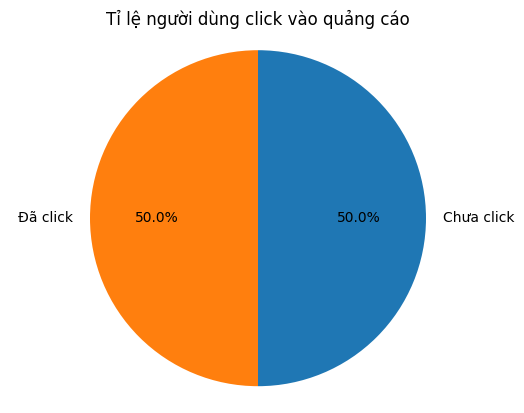

In [6]:
plt.pie(df['Clicked on Ad'].value_counts(), labels=['Chưa click', 'Đã click'], autopct='%1.1f%%', startangle=90, counterclock=False)
plt.axis('equal')
plt.title('Tỉ lệ người dùng click vào quảng cáo')
plt.show()

## **Yêu cầu 3:** Xử lý dữ liệu missing, duplicates, outliers

### Xử lý dữ liệu missing

Xử lý dữ liệu bị thiếu bằng nội suy tuyến tính

In [7]:
df, _, _ = handle_missing_data(df, 4)
df

C:\Users\Hi\AppData\Local\Temp\ipykernel_12808\3593029240.py:41: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  new_df = df.interpolate()       # Điền bằng phương pháp nội suy tuyến tính


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,27/3/2016 0:53,0
1,80.23,31.0,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,13/3/2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,10/1/2016 2:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,3/6/2016 3:36,0
...,...,...,...,...,...,...,...,...,...,...
997,51.30,45.0,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,22/4/2016 2:07,1
998,51.63,51.0,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,1/2/2016 17:24,1
999,55.55,19.0,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,24/3/2016 2:35,0
1000,45.01,33.5,29875.80,178.35,Virtual 5thgeneration emulation,Ronniemouth,0,Brazil,3/6/2016 21:43,1


### Xử lý dữ liệu duplicates

Xử lý dữ liệu bị lặp bằng cách xóa chúng khỏi DataFrame

In [8]:
df,_ = handle_duplicate_data(df)
df

Dữ liệu có 2 dòng bị trùng lặp.
Xóa thành công các dòng bị trùng lặp.


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,27/3/2016 0:53,0
1,80.23,31.0,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,13/3/2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,10/1/2016 2:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,3/6/2016 3:36,0
...,...,...,...,...,...,...,...,...,...,...
996,72.97,30.0,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,11/2/2016 21:49,1
997,51.30,45.0,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,22/4/2016 2:07,1
998,51.63,51.0,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,1/2/2016 17:24,1
999,55.55,19.0,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,24/3/2016 2:35,0


### Xử lý dữ liệu outliers

Xử lý dữ liệu ngoại lai bằng phương pháp Z-score

In [9]:
def handle_outlier_data(df=pd.DataFrame, handle=0):
    """
    Xử lý ngoại lai trong DataFrame.

    Args:
        df (DataFrame): DataFrame chứa dữ liệu.
        handle (str): Phương pháp xử lý ngoại lai.
            0: Sử dụng phương pháp Z-score.
            1: Sử dụng phương pháp tứ phân vị.

    Returns:
        tuple: Một tuple chứa hai DataFrame:
            new_df (DataFrame): DataFrame sau khi xử lý các giá trị ngoại lai.
            outliers (DataFrame): DataFrame chứa các giá trị ngoại lai.
    """

    new_df = df.copy()
    numerical_columns = df.select_dtypes(include=np.number).copy()  # Cột dữ liệu kiểu số
    outliers = pd.DataFrame()

    if handle == 0:
        # Tính Z-score
        for column in numerical_columns:
            col_mean = numerical_columns[column].mean()
            col_std = numerical_columns[column].std()
            numerical_columns[column] = (numerical_columns[column] - col_mean) / col_std

        # Xác định ngoại lai bằng Z-score
        threshold = 3
        z_scores = numerical_columns.abs() > threshold
        outliers = df[z_scores.any(axis=1)]
        new_df = df[~z_scores.any(axis=1)]
    elif handle == 1:
        # Tính tứ phân vị và xác định ngoại lai
        Q1 = numerical_columns.quantile(0.25)
        Q3 = numerical_columns.quantile(0.75)
        IQR = Q3 - Q1

        # Tính giới hạn trên và dưới
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Tạo DataFrame đánh dấu ngoại lai
        is_outlier = (numerical_columns < lower_bound) | (numerical_columns > upper_bound)
        outliers = df[is_outlier.any(axis=1)]
        new_df = df[~is_outlier.any(axis=1)]

    return new_df, outliers

df, _ = handle_outlier_data(df)
df

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,27/3/2016 0:53,0
1,80.23,31.0,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,4/4/2016 1:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,13/3/2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,10/1/2016 2:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,3/6/2016 3:36,0
...,...,...,...,...,...,...,...,...,...,...
996,72.97,30.0,71384.57,208.58,Fundamental modular algorithm,Duffystad,1,Lebanon,11/2/2016 21:49,1
997,51.30,45.0,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,1,Bosnia and Herzegovina,22/4/2016 2:07,1
998,51.63,51.0,42415.72,120.37,Expanded intangible solution,South Jessica,1,Mongolia,1/2/2016 17:24,1
999,55.55,19.0,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,0,Guatemala,24/3/2016 2:35,0


## **Yêu cầu 4:** Phân tích đơn biến (Univariate Analysis), song biến (Bivariate Analysis)

### Phân tích đơn biến

count    998.000000
mean      64.995351
std       15.869052
min       32.600000
25%       51.320000
50%       68.215000
75%       78.562500
max       91.430000
Name: Daily Time Spent on Site, dtype: float64


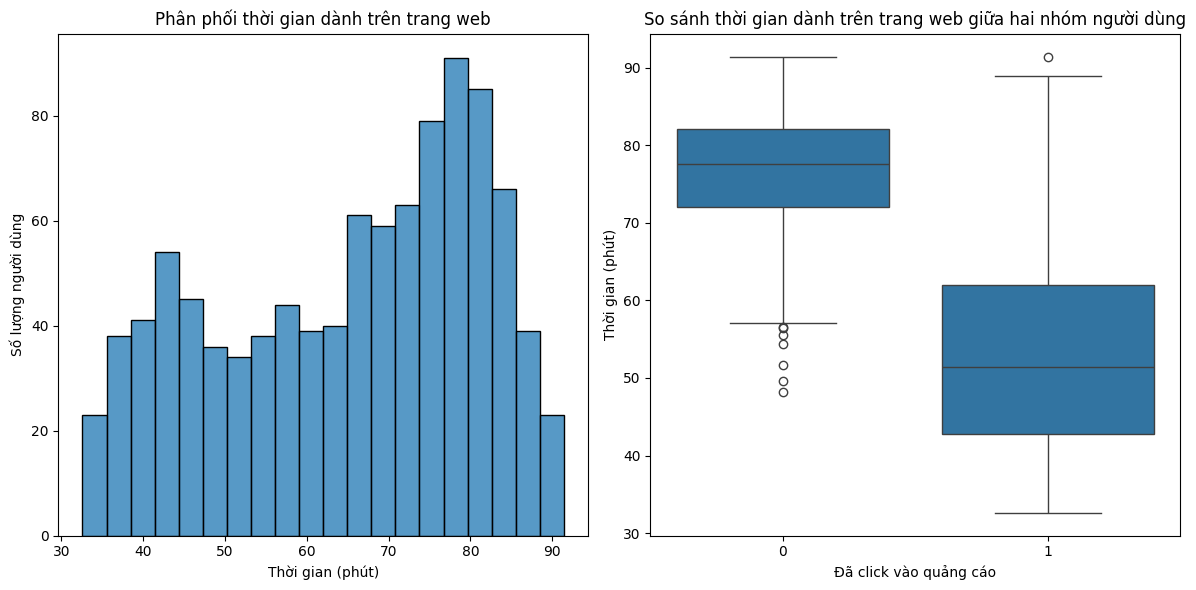

In [10]:
# Thống kê mô tả
print(df['Daily Time Spent on Site'].describe())

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Vẽ histogram
sns.histplot(data=df, x='Daily Time Spent on Site', bins=20, ax=axes[0])
axes[0].set_title('Phân phối thời gian dành trên trang web')
axes[0].set_xlabel('Thời gian (phút)')
axes[0].set_ylabel('Số lượng người dùng')

# Vẽ boxplot
sns.boxplot(x='Clicked on Ad', y='Daily Time Spent on Site', data=df, ax=axes[1])
axes[1].set_title('So sánh thời gian dành trên trang web giữa hai nhóm người dùng')
axes[1].set_ylabel('Thời gian (phút)')
axes[1].set_xlabel('Đã click vào quảng cáo')

plt.tight_layout()
plt.show()

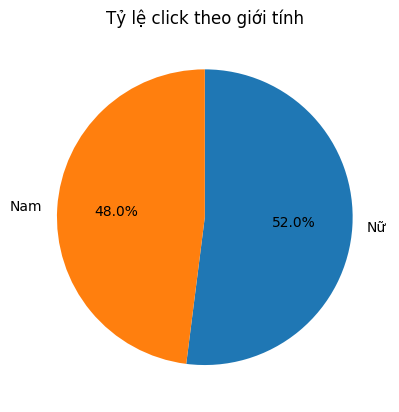

In [11]:
# Tính tỷ lệ click theo giới tính
gender_counts = df['Male'].value_counts()
plt.pie(gender_counts, labels=['Nữ', 'Nam'], autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Tỷ lệ click theo giới tính')

plt.show()

### Phân tích đa biến


In [12]:
# Tính hệ số tương quan giữa thời gian trên trang web và tỷ lệ click, loại bỏ các cột không cần thiết (abs < 0.3)
numerical_columns = df.select_dtypes(include=np.number).copy().drop('Clicked on Ad', axis=1)

for col in numerical_columns:
    correlation = df[col].corr(df['Clicked on Ad'])
    print(f'Hệ số tương quan của `{col}`:', correlation)
    if abs(correlation) < 0.4:
        df = df.drop(col, axis=1)

numerical_columns = df.select_dtypes(include=np.number).copy().drop('Clicked on Ad', axis=1)
df

Hệ số tương quan của `Daily Time Spent on Site`: -0.7491951702415494
Hệ số tương quan của `Age`: 0.4928231795369545
Hệ số tương quan của `Area Income`: -0.4750518488521388
Hệ số tương quan của `Daily Internet Usage`: -0.7871279887356929
Hệ số tương quan của `Male`: -0.04019285819279581


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Country,Timestamp,Clicked on Ad
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,Tunisia,27/3/2016 0:53,0
1,80.23,31.0,68441.85,193.77,Monitored national standardization,West Jodi,Nauru,4/4/2016 1:39,0
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,San Marino,13/3/2016 20:35,0
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,Italy,10/1/2016 2:31,0
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,Iceland,3/6/2016 3:36,0
...,...,...,...,...,...,...,...,...,...
996,72.97,30.0,71384.57,208.58,Fundamental modular algorithm,Duffystad,Lebanon,11/2/2016 21:49,1
997,51.30,45.0,67782.17,134.42,Grass-roots cohesive monitoring,New Darlene,Bosnia and Herzegovina,22/4/2016 2:07,1
998,51.63,51.0,42415.72,120.37,Expanded intangible solution,South Jessica,Mongolia,1/2/2016 17:24,1
999,55.55,19.0,41920.79,187.95,Proactive bandwidth-monitored policy,West Steven,Guatemala,24/3/2016 2:35,0


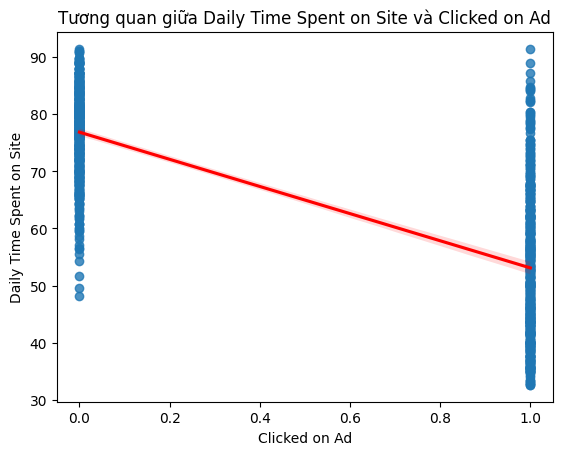

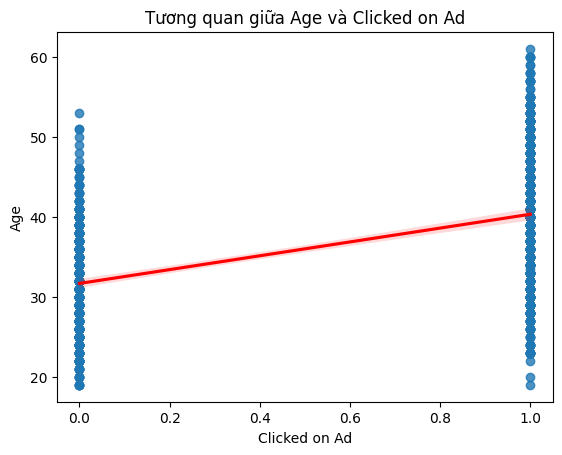

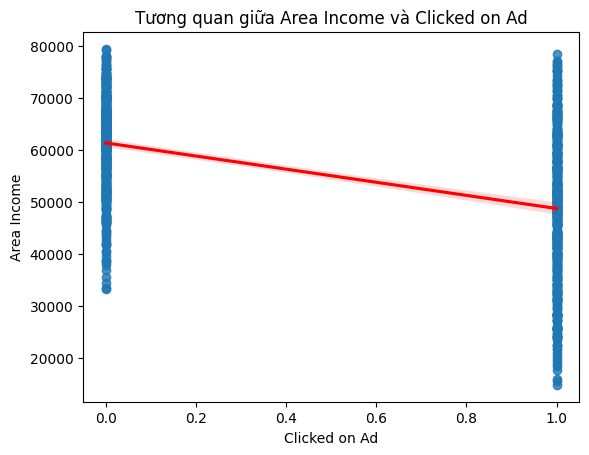

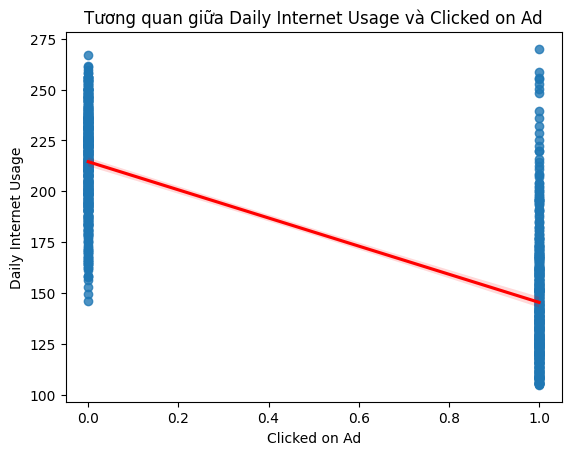

In [13]:
# Vẽ các biểu đồ scatter plot
for col in numerical_columns:
    sns.regplot(x='Clicked on Ad', y=col, data=df, line_kws={'color': 'red'})
    plt.title(f'Tương quan giữa {col} và Clicked on Ad')
    plt.xlabel('Clicked on Ad')
    plt.ylabel(col)
    plt.show()

## **Yêu cầu 5:** Kết luận các điểm chính quan sát được từ dữ liệu

**Kết luận các điểm chính quan sát được từ dữ liệu**


Dựa trên 3 nhận xét đã phân tích về hệ số tương quan và dữ liệu, ta rút ra được những kết luận chính sau:
- Ảnh hưởng của các yếu tố đến thời gian sử dụng trang web:
    - Thu nhập và thời gian: Người dùng đến từ các khu vực có thu nhập cao có xu hướng dành ít thời gian hơn trên trang web so với những người đến từ khu vực có thu nhập thấp. Điều này có thể do nhiều nguyên nhân, chẳng hạn như người có thu nhập cao có nhiều lựa chọn giải trí khác hoặc có ít thời gian rảnh hơn.
    - Lượng dữ liệu internet và thời gian: Người dùng sử dụng nhiều dữ liệu internet thường dành ít thời gian hơn trên trang web cụ thể này. Điều này cho thấy họ có nhiều hoạt động trực tuyến khác hoặc có kết nối internet ổn định hơn, cho phép họ dễ dàng chuyển đổi giữa các trang web.
    - Tuổi tác và thời gian: Người trẻ tuổi có xu hướng dành nhiều thời gian hơn trên trang web so với người lớn tuổi. Tuy nhiên, mối quan hệ này không mạnh bằng mối quan hệ giữa thu nhập, lượng dữ liệu internet và thời gian.
- Giới tính và thời gian:
    - Giới tính không ảnh hưởng đáng kể đến thời gian sử dụng trang web. Điều này cho thấy nội dung của trang web có thể hấp dẫn cả nam và nữ ở mức độ tương đương.

## **Yêu cầu 6:** Quan sát và nhận xét về:

### Thời gian sử dụng website theo độ tuổi, theo thu nhập, thành phố

Hệ số tương quan giữa `Age` và `Daily Time Spent on Site`: -0.33334706762637656

                               OLS Regression Results                               
Dep. Variable:     Daily Time Spent on Site   R-squared:                       0.111
Model:                                  OLS   Adj. R-squared:                  0.110
Method:                       Least Squares   F-statistic:                     124.5
Date:                      Sat, 14 Dec 2024   Prob (F-statistic):           2.51e-27
Time:                              21:17:16   Log-Likelihood:                -4115.7
No. Observations:                       998   AIC:                             8235.
Df Residuals:                           996   BIC:                             8245.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

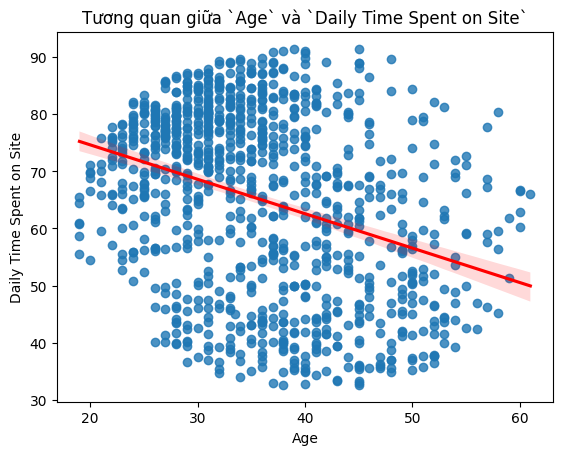

In [14]:
# Hệ số tương quan giữa 'Thời gian sử dung website' và 'Độ tuổi'
correlation_age = df['Daily Time Spent on Site'].corr(df['Age'])
print(f'Hệ số tương quan giữa `Age` và `Daily Time Spent on Site`: {correlation_age}\n')
# Scatterplot
sns.regplot(x='Age', y='Daily Time Spent on Site', data=df, line_kws={'color': 'red'})
plt.title('Tương quan giữa `Age` và `Daily Time Spent on Site`')
plt
# Mô hình hồi quy
Y = df['Daily Time Spent on Site']
X = df['Age']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

**Nhận xét**:
- Hệ số tương quan là -0.335, cho thấy mối quan hệ nghịch chiều. Khi độ tuổi tăng, thời gian sử dụng website có xu hướng giảm.
- Daily Time Spent on Site = 86.6837 - 0.624 * Age

  Age_Group  Daily Time Spent on Site
0       <20                 63.837500
1     20-30                 70.167931
2     30-40                 67.215428
3     40-50                 56.879023
4       50+                 55.979306


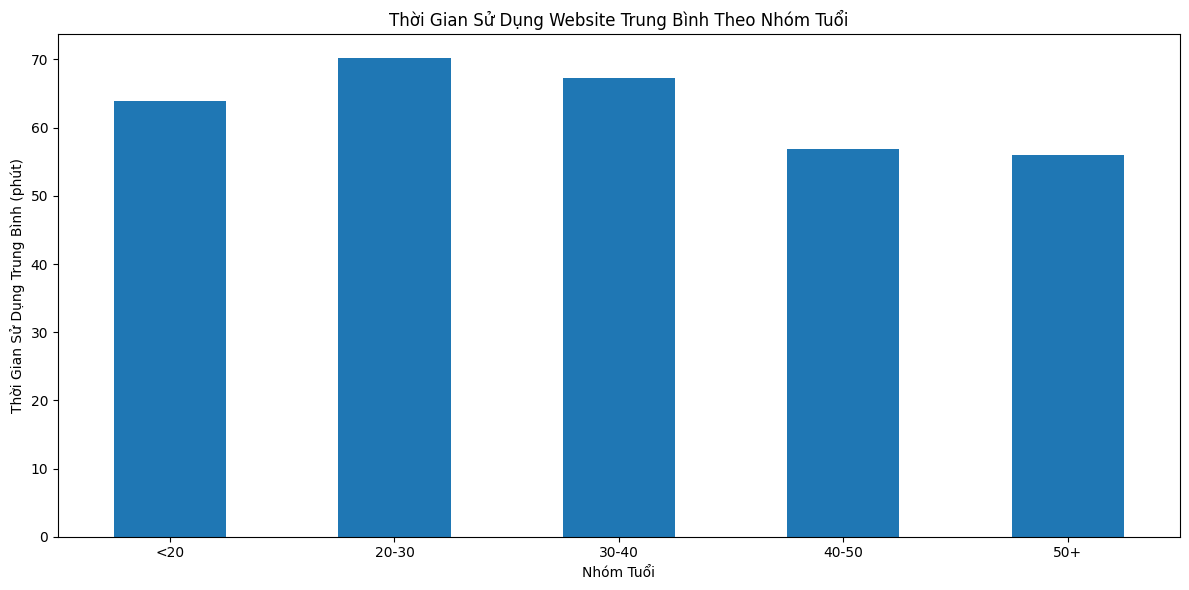

In [15]:
# 1. Phân tích thời gian sử dụng website theo độ tuổi
plt.figure(figsize=(12, 6))

# Chia độ tuổi thành các nhóm
df['Age_Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 100],
                              labels=['<20', '20-30', '30-40', '40-50', '50+'])

# Tính trung bình thời gian sử dụng cho mỗi nhóm tuổi
age_time_avg = df.groupby('Age_Group', observed=True)['Daily Time Spent on Site'].mean()

ata = df.groupby('Age_Group', observed=True).agg({'Daily Time Spent on Site': 'mean'}).reset_index()
print(ata)

# Vẽ biểu đồ cột
age_time_avg.plot(kind='bar')
plt.title('Thời Gian Sử Dụng Website Trung Bình Theo Nhóm Tuổi')
plt.xlabel('Nhóm Tuổi')
plt.ylabel('Thời Gian Sử Dụng Trung Bình (phút)')
plt.xticks(rotation=0, ha='center')
plt.tight_layout()
plt.show()

  Income_Group  Daily Time Spent on Site
0         <30k                 57.130000
1      30k-50k                 57.271560
2      50k-70k                 68.507135
3         >70k                 68.095217


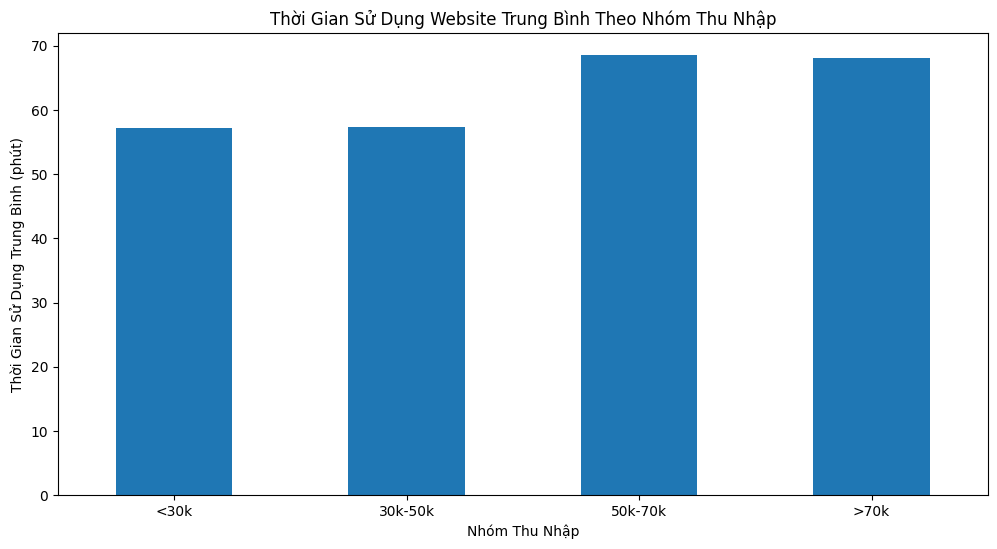

In [16]:
# 2. Phân tích thời gian sử dụng website theo thu nhập
plt.figure(figsize=(12, 6))

# Chia thu nhập thành các nhóm
df['Income_Group'] = pd.cut(df['Area Income'], bins=[0, 30000, 50000, 70000, 80000], labels=['<30k', '30k-50k', '50k-70k', '>70k'])

# Tính trung bình thời gian sử dụng cho mỗi nhóm thu nhập
income_time_avg = df.groupby('Income_Group', observed=True)['Daily Time Spent on Site'].mean()

ita = df.groupby('Income_Group', observed=True).agg({'Daily Time Spent on Site': 'mean'}).reset_index()
print(ita)

# Vẽ biểu đồ cột
income_time_avg.plot(kind='bar')
plt.title('Thời Gian Sử Dụng Website Trung Bình Theo Nhóm Thu Nhập')
plt.xlabel('Nhóm Thu Nhập')
plt.ylabel('Thời Gian Sử Dụng Trung Bình (phút)')
plt.xticks(rotation=0, ha='center')
# plt.tight_layout()
plt.show()

Hệ số tương quan giữa `Area Income` và `Daily Time Spent on Site`: 0.3148203451527539

                               OLS Regression Results                               
Dep. Variable:     Daily Time Spent on Site   R-squared:                       0.099
Model:                                  OLS   Adj. R-squared:                  0.098
Method:                       Least Squares   F-statistic:                     109.6
Date:                      Sat, 14 Dec 2024   Prob (F-statistic):           2.12e-24
Time:                              21:17:17   Log-Likelihood:                -4122.4
No. Observations:                       998   AIC:                             8249.
Df Residuals:                           996   BIC:                             8259.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [0

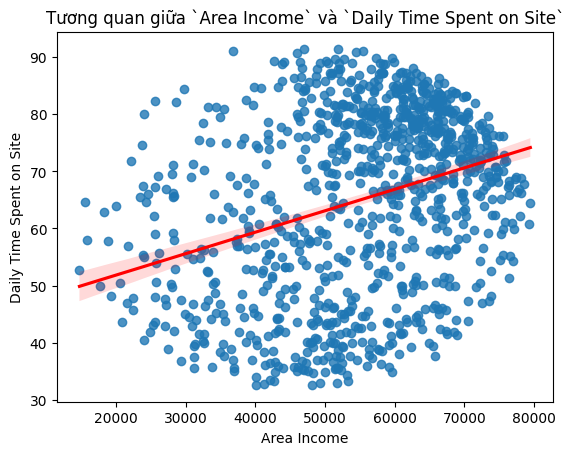

In [17]:
#Hệ số tương quan giữa 'Thời gian sử dụng website' và 'Thu nhập'
correlation_income = df['Daily Time Spent on Site'].corr(df['Area Income'])
print(f'Hệ số tương quan giữa `Area Income` và `Daily Time Spent on Site`: {correlation_income}\n')

#Scatterplot
sns.regplot(x='Area Income', y='Daily Time Spent on Site', data=df, line_kws={'color': 'red'})
plt.title('Tương quan giữa `Area Income` và `Daily Time Spent on Site`')
plt

#Mô hình hồi quy
Y = df['Daily Time Spent on Site']
X = df['Area Income']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

**Nhận xét**:
- Hệ số tương quan là 0.315, cho thấy mối quan hệ thuận chiều. Khi thu nhập tăng, thời gian sử dụng website có xu hướng tăng theo.
- Daily Time Spent on Site = 44.3102 - 0.004 * Area Income

                        Country               City  Daily Time Spent on Site
0              French Polynesia    West Carmenfurt                     91.43
1                    Kazakhstan        Lawsonshire                     91.37
2                        Cyprus        Joshuamouth                     91.15
3                       Bolivia       Michaelmouth                     91.10
4                         Congo       Kimberlytown                     90.97
5                          Togo        Lake Joseph                     90.75
6                      Maldives     Wallacechester                     89.91
7                       Lesotho        West Tanner                     89.80
8                       Bahrain           Sarafurt                     89.71
9                       Armenia       Nicholasport                     89.66
10                    Australia        Port Stacey                     89.37
11                     Paraguay           Wendyton                     89.34

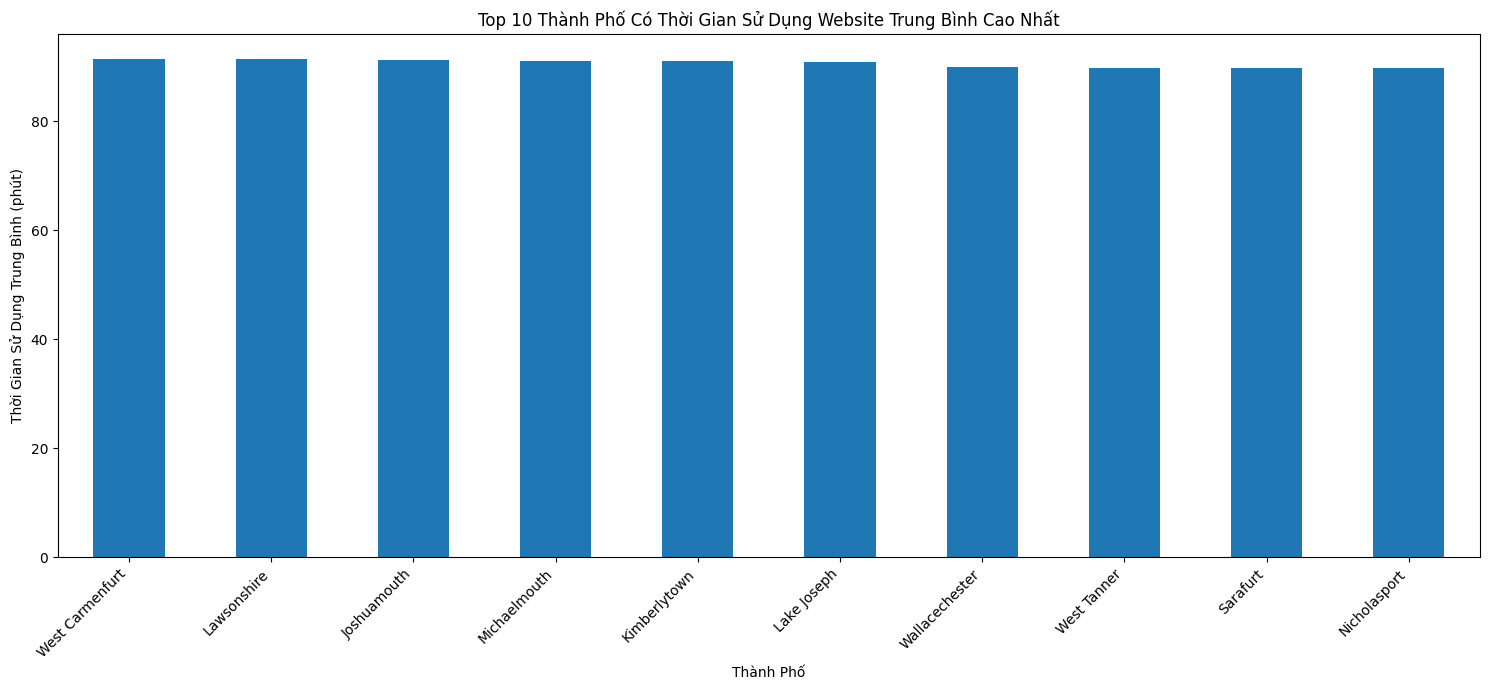

In [18]:
# 3. Phân tích thời gian sử dụng website theo thành phố

plt.figure(figsize=(15, 7))

# Tính trung bình thời gian sử dụng cho mỗi thành phố
city_time_avg = df.groupby('City', observed=True)['Daily Time Spent on Site'].mean().sort_values(ascending=False)

cta = df.groupby(['Country', 'City'], observed=True).agg({'Daily Time Spent on Site': 'mean'}).sort_values('Daily Time Spent on Site', ascending=False).reset_index()
print(cta.head(20))

# Vẽ biểu đồ cột cho top 10 thành phố
top_10_cities = city_time_avg.head(10)
top_10_cities.plot(kind='bar')
plt.title('Top 10 Thành Phố Có Thời Gian Sử Dụng Website Trung Bình Cao Nhất')
plt.xlabel('Thành Phố')
plt.ylabel('Thời Gian Sử Dụng Trung Bình (phút)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Thời điểm trong ngày (sáng, trưa, chiều, tối)

Phân loại thời gian

In [19]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

# Hàm phân loại thời điểm trong ngày
def classify_daytime(timestamp):
    hour = timestamp.hour
    if 5 <= hour < 11:
        return 'Sáng'
    elif 11 <= hour < 14:
        return 'Trưa'
    elif 14 <= hour < 18:
        return 'Chiều'
    else:
        return 'Tối'

# Thêm cột phân loại thời điểm trong ngày
df['Daytime'] = df['Timestamp'].apply(classify_daytime)

# Phân tích thời gian sử dụng website theo thời điểm trong ngày
daytime_analysis = df.groupby('Daytime', observed = True)['Daily Time Spent on Site'].agg(['mean', 'count'])
daytime_analysis = daytime_analysis.sort_values('mean', ascending=False)

print("Phân Tích Thời Gian Sử Dụng Website Theo Thời Điểm Trong Ngày:")
print(daytime_analysis)

Phân Tích Thời Gian Sử Dụng Website Theo Thời Điểm Trong Ngày:
              mean  count
Daytime                  
Tối      65.731518    461
Trưa     64.932605    119
Sáng     64.548269    260
Chiều    63.630380    158


Tính toán các thống kê

In [20]:
# Tính toán các thống kê
df.groupby('Daytime')['Daily Time Spent on Site'].describe()

,count,mean,std,min,25%,50%,75%,max
Daytime,,,,,,,,
Chiều,158.0,63.630380,15.920200,32.91,50.5475,66.630,77.145,89.91
Sáng,260.0,64.548269,16.403053,33.33,49.9225,67.365,78.980,91.37
Trưa,119.0,64.932605,15.357700,34.66,51.5700,67.390,78.280,89.37
Tối,461.0,65.731518,15.684711,32.60,53.3800,69.000,78.740,91.43


In [21]:
# Tương quan giữa 'Thời gian sử dụng website' và 'Thời điểm trong ngày'
# Mô hình hồi quy
#Encode cột 'Daytime'
le = LabelEncoder()
df['Daytime_idx'] = le.fit_transform(df['Daytime'])
Y = df['Daily Time Spent on Site']
X = df['Daytime_idx']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Daily Time Spent on Site   R-squared:                       0.002
Model:                                  OLS   Adj. R-squared:                  0.001
Method:                       Least Squares   F-statistic:                     2.335
Date:                      Sat, 14 Dec 2024   Prob (F-statistic):              0.127
Time:                              21:17:18   Log-Likelihood:                -4173.3
No. Observations:                       998   AIC:                             8351.
Df Residuals:                           996   BIC:                             8360.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

**Nhận xét**:
- Mô hình hồi quy không giải thích tốt sự thay đổi trong Daily Time Spent on Site (do R-squared rất thấp và F-statistic có giá trị p lớn).
- Biến Time of Day_idx không có ảnh hưởng có ý nghĩa thống kê đối với Daily Time Spent on Site (P>|t| lớn hơn 0.05).


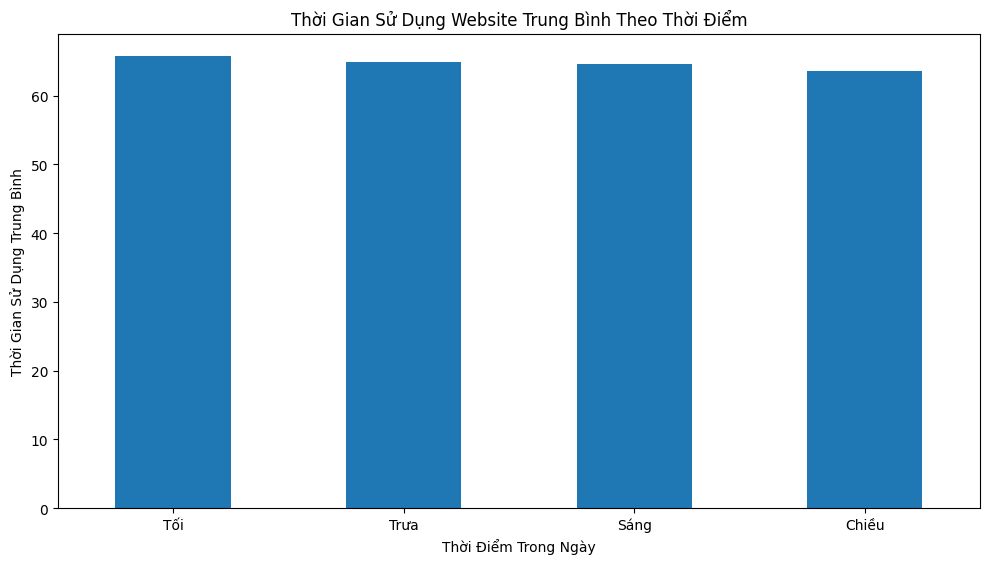

In [22]:
# Biểu đồ thời gian sử dụng trung bình
plt.figure(figsize=(10, 6))
daytime_analysis['mean'].plot(kind='bar')
plt.title('Thời Gian Sử Dụng Website Trung Bình Theo Thời Điểm')
plt.xlabel('Thời Điểm Trong Ngày')
plt.ylabel('Thời Gian Sử Dụng Trung Bình')
plt.tight_layout()
plt.xticks(rotation=0, ha='center')
plt.show()

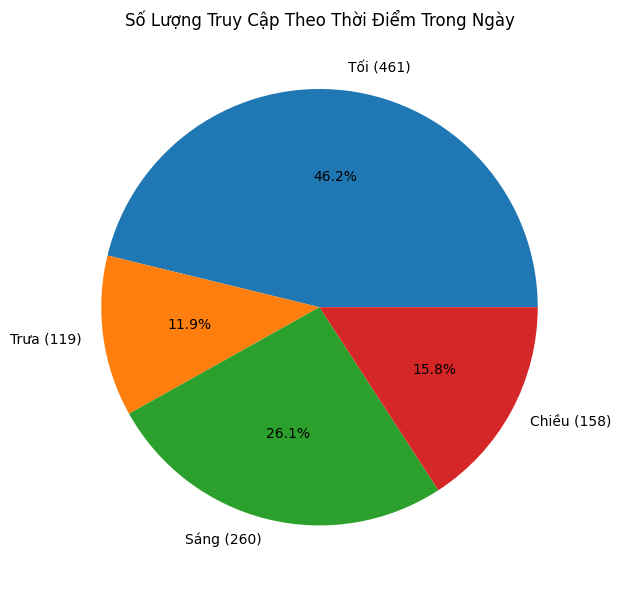

In [23]:
# Biểu đồ tròn về số lượng truy cập
plt.figure(figsize=(10, 6))
plt.pie(daytime_analysis['count'],
        labels=[f'{index} ({count})' for index, count in daytime_analysis['count'].items()],
        autopct='%1.1f%%')
plt.title('Số Lượng Truy Cập Theo Thời Điểm Trong Ngày')
plt.tight_layout()
plt.show()

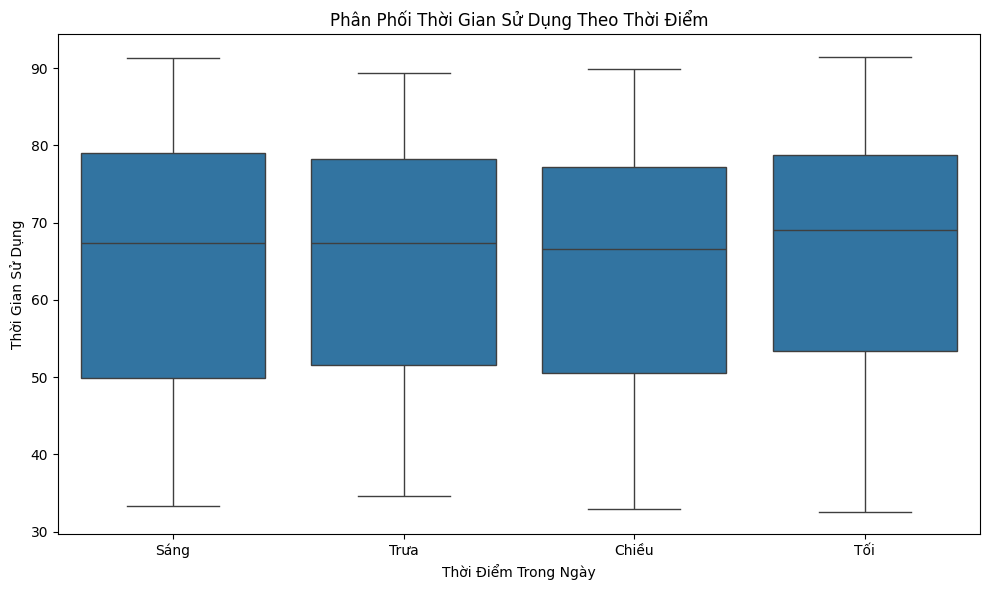

In [24]:
# Boxplot về thời gian sử dụng
plt.figure(figsize=(10, 6))
sns.boxplot(x='Daytime', y='Daily Time Spent on Site', data=df, order=['Sáng', 'Trưa', 'Chiều', 'Tối'])
plt.title('Phân Phối Thời Gian Sử Dụng Theo Thời Điểm')
plt.xlabel('Thời Điểm Trong Ngày')
plt.ylabel('Thời Gian Sử Dụng')
plt.tight_layout()
plt.show()

### Chủ đề quản cáo được quan tâm nhất hoặc ít được quan tâm nhất

In [25]:
clicked_ads = df[df['Clicked on Ad'] == 1]

# Nhóm theo Ad Topic Line và đếm số lần được click
ad_topic_clicks = clicked_ads.groupby('Ad Topic Line').agg({'Clicked on Ad':'sum'}).reset_index()
ad_topic_clicks.columns = ['Ad Topic Line', 'Number of Clicks']

# Tính tổng số quảng cáo cho mỗi chủ đề
total_ads = clicked_ads.groupby('Ad Topic Line').size().reset_index(name='Total Ads')

# Merge để có thêm thông tin về tổng số quảng cáo
ad_topic_performance = pd.merge(ad_topic_clicks, total_ads, on='Ad Topic Line')

# Tính tỷ lệ click
ad_topic_performance['Click Rate'] = ad_topic_performance['Number of Clicks'] / ad_topic_performance['Total Ads']

# Sắp xếp theo số lượng click giảm dần
print("Phân loại chủ đề quảng cáo được click:")
ad_topic_performance.sort_values('Number of Clicks', ascending=False)

Phân loại chủ đề quảng cáo được click:


,Ad Topic Line,Number of Clicks,Total Ads,Click Rate
497,Visionary mission-critical application,1,1,1.0
0,Adaptive asynchronous attitude,1,1,1.0
481,Versatile transitional monitoring,1,1,1.0
480,Versatile solution-oriented secured line,1,1,1.0
479,Versatile scalable encryption,1,1,1.0
...,...,...,...,...
6,Advanced disintermediate data-warehouse,1,1,1.0
5,Advanced 24/7 productivity,1,1,1.0
4,Adaptive uniform capability,1,1,1.0
3,Adaptive demand-driven knowledgebase,1,1,1.0


In [26]:
#Ad ít được quan tâm nhất
print("Ad ít được click nhất:")
not_clicked_ads = df[df['Clicked on Ad'] == 0]

ad_topic = not_clicked_ads.groupby('Ad Topic Line').agg({'Clicked on Ad':'sum'}).reset_index()

ad_topic.columns = ['Ad Topic Line', 'Number of Clicks']

total_ads = not_clicked_ads.groupby('Ad Topic Line').size().reset_index(name='Total Ads')

ad_topic_number = pd.merge(ad_topic, total_ads, on='Ad Topic Line')

ad_topic_number.sort_values('Total Ads', ascending=False)

Ad ít được click nhất:


,Ad Topic Line,Number of Clicks,Total Ads
499,Visionary reciprocal circuit,0,1
0,Adaptive 24hour Graphic Interface,0,1
1,Advanced 5thgeneration capability,0,1
2,Advanced didactic conglomeration,0,1
483,User-friendly impactful time-frame,0,1
...,...,...,...
8,Ameliorated actuating workforce,0,1
7,Advanced modular Local Area Network,0,1
6,Advanced local task-force,0,1
5,Advanced heuristic firmware,0,1


In [27]:
# Phân loại topic
df['Ad Topic'] = df['Ad Topic Line'].str.extract(r'(^\S+)')

In [28]:
# Số lượng clicks mỗi chủ đề quảng cáo
ad_clicks = df.groupby('Ad Topic')['Clicked on Ad'].sum()

# Lấy tất cả các dòng có lượt click cao nhất và thấp nhất
max_clicks = ad_clicks.max()
min_clicks = ad_clicks.min()
most_clicked_ad = ad_clicks[ad_clicks == max_clicks]
least_clicked_ad = ad_clicks[ad_clicks == min_clicks]


print("Most clicked ads:\n", most_clicked_ad.to_string())
print("Least clicked ads:\n", least_clicked_ad.to_string())

Most clicked ads:
 Ad Topic
Versatile    11
Least clicked ads:
 Ad Topic
Multi-lateral    1
Persistent       1


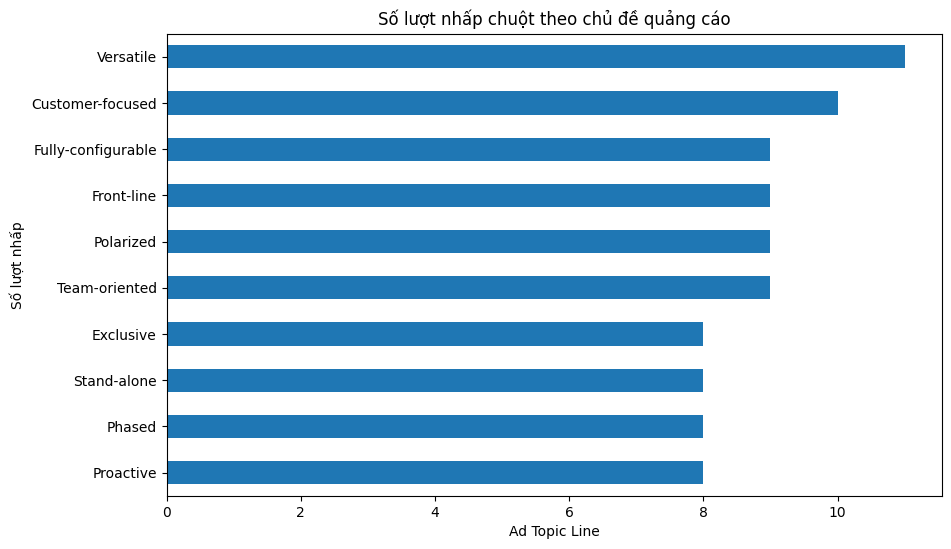

In [29]:
# Top 10 chủ đề nổi bậc
top = ad_clicks.sort_values(ascending=False).head(10)

# # Biểu đồ tỷ lệ nhấp chuột theo chủ đề quảng cáo
plt.figure(figsize=(10, 6))
top.plot(kind='barh')
plt.title('Số lượt nhấp chuột theo chủ đề quảng cáo')
plt.xlabel('Ad Topic Line')
plt.ylabel('Số lượt nhấp')
plt.gca().invert_yaxis()
plt.show()

## **Yêu cầu 7:** Dự đoán khả năng 1 người dùng có chọn xem quảng cáo được hiển thị hay không (lựa chọn và cài đặt thuật toán, cài đặt ít nhất 2 thuật toán để so sánh với nhau)

In [30]:
df.head(10)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Country,Timestamp,Clicked on Ad,Age_Group,Income_Group,Daytime,Daytime_idx,Ad Topic
0,68.95,35.0,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,Tunisia,2016-03-27 00:53:00,0,30-40,50k-70k,Tối,3,Cloned
1,80.23,31.0,68441.85,193.77,Monitored national standardization,West Jodi,Nauru,2016-04-04 01:39:00,0,30-40,50k-70k,Tối,3,Monitored
2,69.47,26.0,59785.94,236.50,Organic bottom-line service-desk,Davidton,San Marino,2016-03-13 20:35:00,0,20-30,50k-70k,Tối,3,Organic
3,74.15,29.0,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,Italy,2016-01-10 02:31:00,0,20-30,50k-70k,Tối,3,Triple-buffered
4,68.37,35.0,73889.99,225.58,Robust logistical utilization,South Manuel,Iceland,2016-06-03 03:36:00,0,30-40,>70k,Tối,3,Robust
5,59.99,23.0,59761.56,226.74,Sharable client-driven software,Jamieberg,Norway,2016-05-19 14:30:00,0,20-30,50k-70k,Chiều,0,Sharable
6,88.91,33.0,53852.85,208.36,Enhanced dedicated support,Brandonstad,Myanmar,2016-01-28 20:59:00,0,30-40,50k-70k,Tối,3,Enhanced
7,66.00,48.0,24593.33,131.76,Reactive local challenge,Port Jefferybury,Australia,2016-03-07 01:40:00,1,40-50,<30k,Tối,3,Reactive
8,74.53,30.0,68862.00,221.51,Configurable coherent function,West Colin,Grenada,2016-04-18 09:33:00,0,20-30,50k-70k,Sáng,1,Configurable
9,69.88,20.0,55642.32,183.82,Mandatory homogeneous architecture,Ramirezton,Ghana,2016-07-11 01:42:00,0,<20,50k-70k,Tối,3,Mandatory


In [31]:
# Tiền xử lý dữ liệu
# Mã hóa các biến danh mục
df_encoded = pd.get_dummies(df, columns=['Ad Topic Line', 'City', 'Country', 'Age_Group', 'Income_Group', 'Daytime', 'Ad Topic'])

# Chia các đặc trưng và nhãn
X = df_encoded.drop(['Clicked on Ad', 'Timestamp'], axis=1)
y = df_encoded['Clicked on Ad']

# Xử lý missing values bằng SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Hàm đánh giá mô hình
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Đánh giá
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return model

### 7.1 Thuật toán Logistic Regression

**<u>Giới thiệu:</u>**

**Logistic Regression** là một thuật toán học máy thuộc nhóm giám sát (supervised learning), được sử dụng phổ biến để giải quyết các bài toán phân loại nhị phân (binary classification) hoặc phân loại đa lớp (multiclass classification).

**Nguyên lý hoạt động:**
Logistic Regression sử dụng hàm logistic (hay còn gọi là hàm Sigmoid) để ước tính xác suất của một đối tượng thuộc về một lớp. Mô hình này xây dựng một hàm hồi quy tuyến tính và áp dụng hàm Sigmoid để chuyển đổi kết quả thành xác suất trong khoảng từ 0 đến 1.

In [33]:
print("1. Logistic Regression:")
lr_model = evaluate_model(LogisticRegression(random_state=42),
                          X_train_scaled, X_test_scaled, y_train, y_test)


1. Logistic Regression:
Accuracy: 0.93
ROC AUC Score: 0.9770426065162907

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        95
           1       0.96      0.90      0.93       105

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



### 7.2 Thuật toán Decision Tree

**<u>Giới thiệu:</u>**

**Decision Tree**
là một thuật toán học máy được sử dụng cho cả bài toán phân loại và hồi quy, hoạt động bằng cách chia dữ liệu thành các nhóm nhỏ hơn thông qua các điều kiện tại từng nút, tạo thành cấu trúc dạng cây. Mỗi nhánh biểu diễn một điều kiện, và các nút lá là kết quả cuối cùng. Thuật toán sử dụng các tiêu chí như Gini Impurity, Entropy, hoặc Mean Squared Error để đánh giá chất lượng phân tách. Decision Tree dễ hiểu, trực quan và không yêu cầu nhiều tiền xử lý dữ liệu.

In [34]:
print("\n2. Decision Tree:")
dt_model = evaluate_model(DecisionTreeClassifier(random_state=42),
                          X_train, X_test, y_train, y_test)


2. Decision Tree:
Accuracy: 0.955
ROC AUC Score: 0.956140350877193

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        95
           1       0.98      0.93      0.96       105

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200



### 7.3 Thuật toán Random Forest

**<u>Giới thiệu:</u>**

**Random Forest** là một thuật toán học máy mạnh mẽ và phổ biến, thuộc nhóm ensemble learning, nghĩa là kết hợp nhiều mô hình cơ sở (trong trường hợp này là cây quyết định - decision trees) để tạo ra một mô hình tổng thể mạnh mẽ hơn. Thuật toán này có khả năng thực hiện cả phân loại (classification) và hồi quy (regression), nhưng thường được sử dụng phổ biến hơn trong bài toán phân loại.

In [35]:
print("\n3. Random Forest:")
rf_model = evaluate_model(RandomForestClassifier(random_state=42),
                          X_train, X_test, y_train, y_test)


3. Random Forest:
Accuracy: 0.96
ROC AUC Score: 0.9891228070175437

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        95
           1       0.96      0.96      0.96       105

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



### 7.4 Kiểm tra sự ảnh hưởng của thuộc tính thu nhập ảnh hưởng đến mô hình dự đoán

In [36]:
# Cài đặt và huấn luyện mô hình Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Dự đoán mô hình Logistic Regression
y_pred_log_reg = log_reg.predict(X_test)

d:\Others\LanguagePackets\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
# Phân tích tương quan giữa 'Income' và 'Clicked on Ad'
correlation = df['Area Income'].corr(df['Clicked on Ad'])
print("Tương quan giữa Income và Clicked on Ad:", correlation)

# Chạy mô hình không bao gồm 'Income'
X_no_income = df.drop(columns=['Area Income', 'Clicked on Ad', 'Timestamp'])
X_no_income = pd.get_dummies(X_no_income)

# Xử lý missing values bằng SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_No_Income = imputer.fit_transform(X_no_income)

X_no_income_scaled = scaler.fit_transform(X_No_Income)

# Chia dữ liệu
X_train_no_income, X_test_no_income, y_train_n, y_test_n = train_test_split(X_no_income_scaled, y, test_size=0.3, random_state=42)

# Huấn luyện mô hình Logistic Regression không có thu nhập
log_reg_no_income = LogisticRegression(random_state=42)
log_reg_no_income.fit(X_train_no_income, y_train_n)

# Đánh giá mô hình
y_pred_log_reg_no_income = log_reg_no_income.predict(X_test_no_income)
print("Logistic Regression (Không có thu nhập) - Accuracy:", accuracy_score(y_test_n, y_pred_log_reg_no_income))

# So sánh với mô hình có thu nhập
print("So sánh kết quả: \n")
print("Mô hình có thu nhập:")
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("\nMô hình không có thu nhập:")
print("Logistic Regression (Không có thu nhập) - Accuracy:", accuracy_score(y_test_n, y_pred_log_reg_no_income))

Tương quan giữa Income và Clicked on Ad: -0.4750518488521388
Logistic Regression (Không có thu nhập) - Accuracy: 0.9166666666666666
So sánh kết quả: 

Mô hình có thu nhập:
Logistic Regression - Accuracy: 0.915

Mô hình không có thu nhập:
Logistic Regression (Không có thu nhập) - Accuracy: 0.9166666666666666


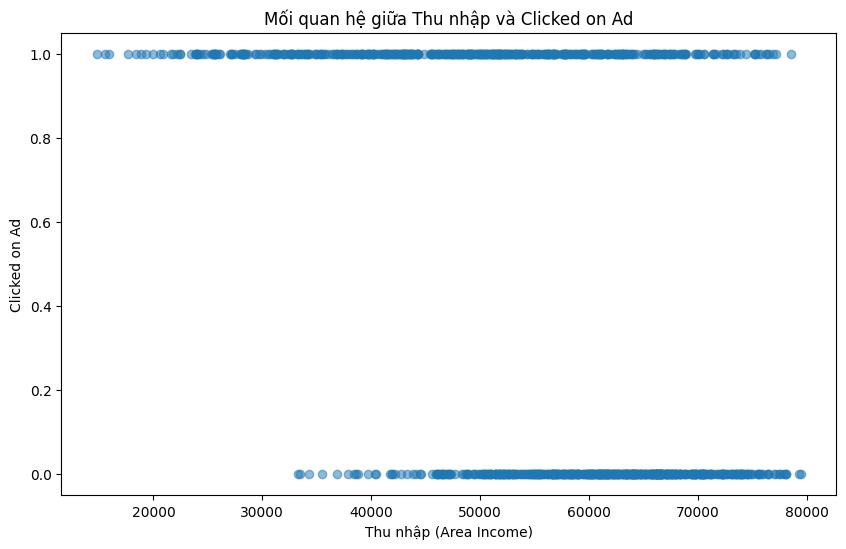

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(X['Area Income'], y, alpha=0.5)
plt.title("Mối quan hệ giữa Thu nhập và Clicked on Ad")
plt.xlabel("Thu nhập (Area Income)")
plt.ylabel("Clicked on Ad")
plt.show()

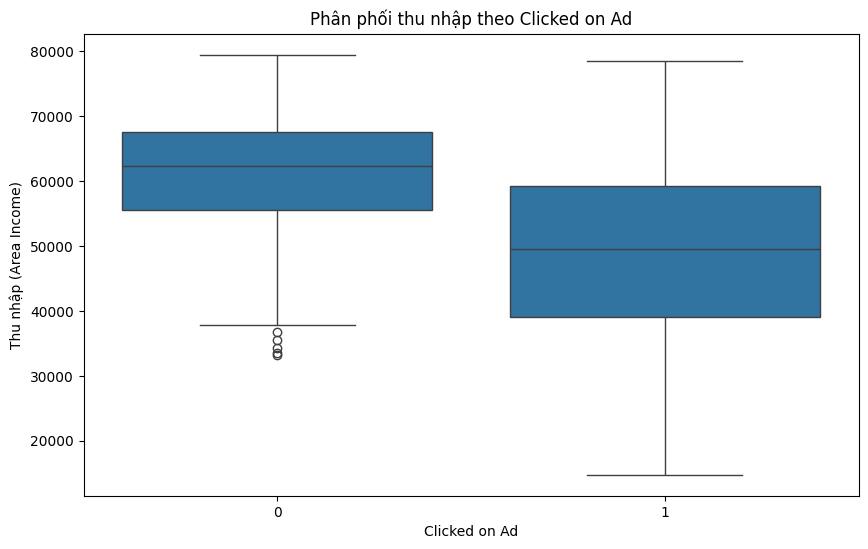

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=y, y=X['Area Income'])
plt.title("Phân phối thu nhập theo Clicked on Ad")
plt.xlabel("Clicked on Ad")
plt.ylabel("Thu nhập (Area Income)")
plt.show()

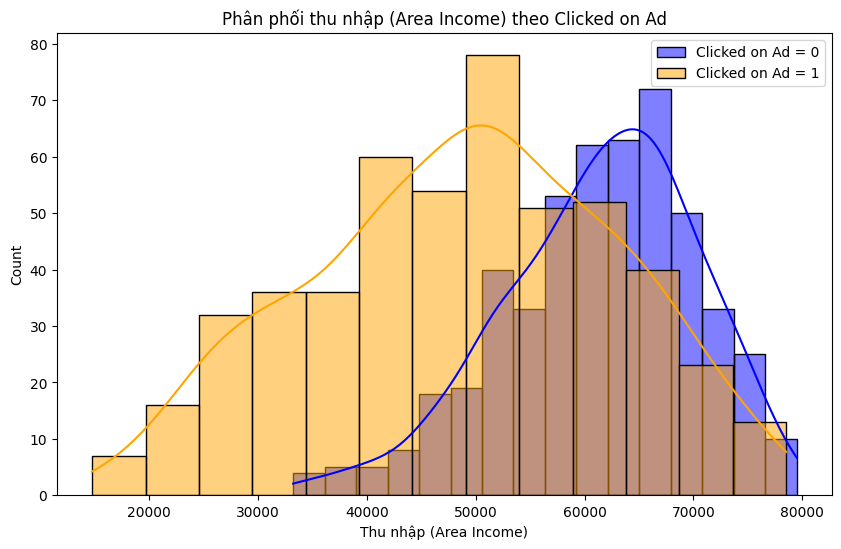

In [40]:
plt.figure(figsize=(10, 6))
sns.histplot(X['Area Income'][y == 0], color='blue', label='Clicked on Ad = 0', kde=True)
sns.histplot(X['Area Income'][y == 1], color='orange', label='Clicked on Ad = 1', kde=True)
plt.title("Phân phối thu nhập (Area Income) theo Clicked on Ad")
plt.xlabel("Thu nhập (Area Income)")
plt.legend()
plt.show()

Kết luận:
- Thu nhập là yếu tố quan trọng trong mô hình dự đoán khả năng nhấp chuột vào quảng cáo. Khi không có thông tin về thu nhập, mô hình có độ chính xác thấp hơn rõ rệt.

### 7.5 Các thuộc tính khác có mối tương quan đến dự đoán khả năng click/không vào quảng cáo

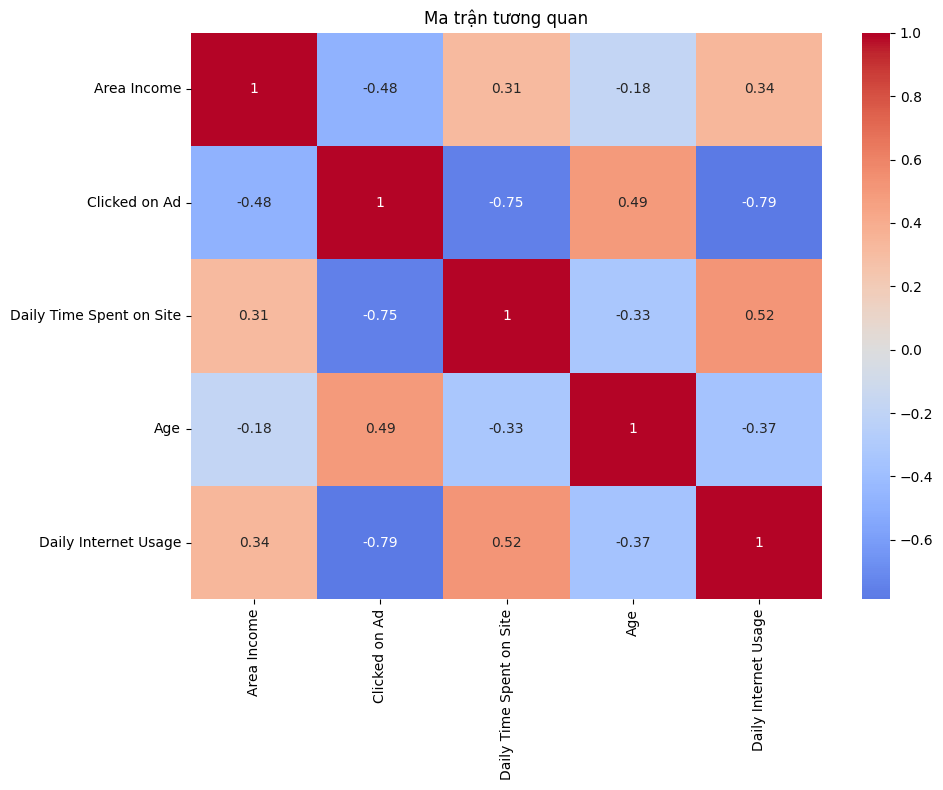

In [41]:
correlation_matrix = df[['Area Income', 'Clicked on Ad', 'Daily Time Spent on Site', 'Age', 'Daily Internet Usage']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Ma trận tương quan')
plt.tight_layout()
plt.show()

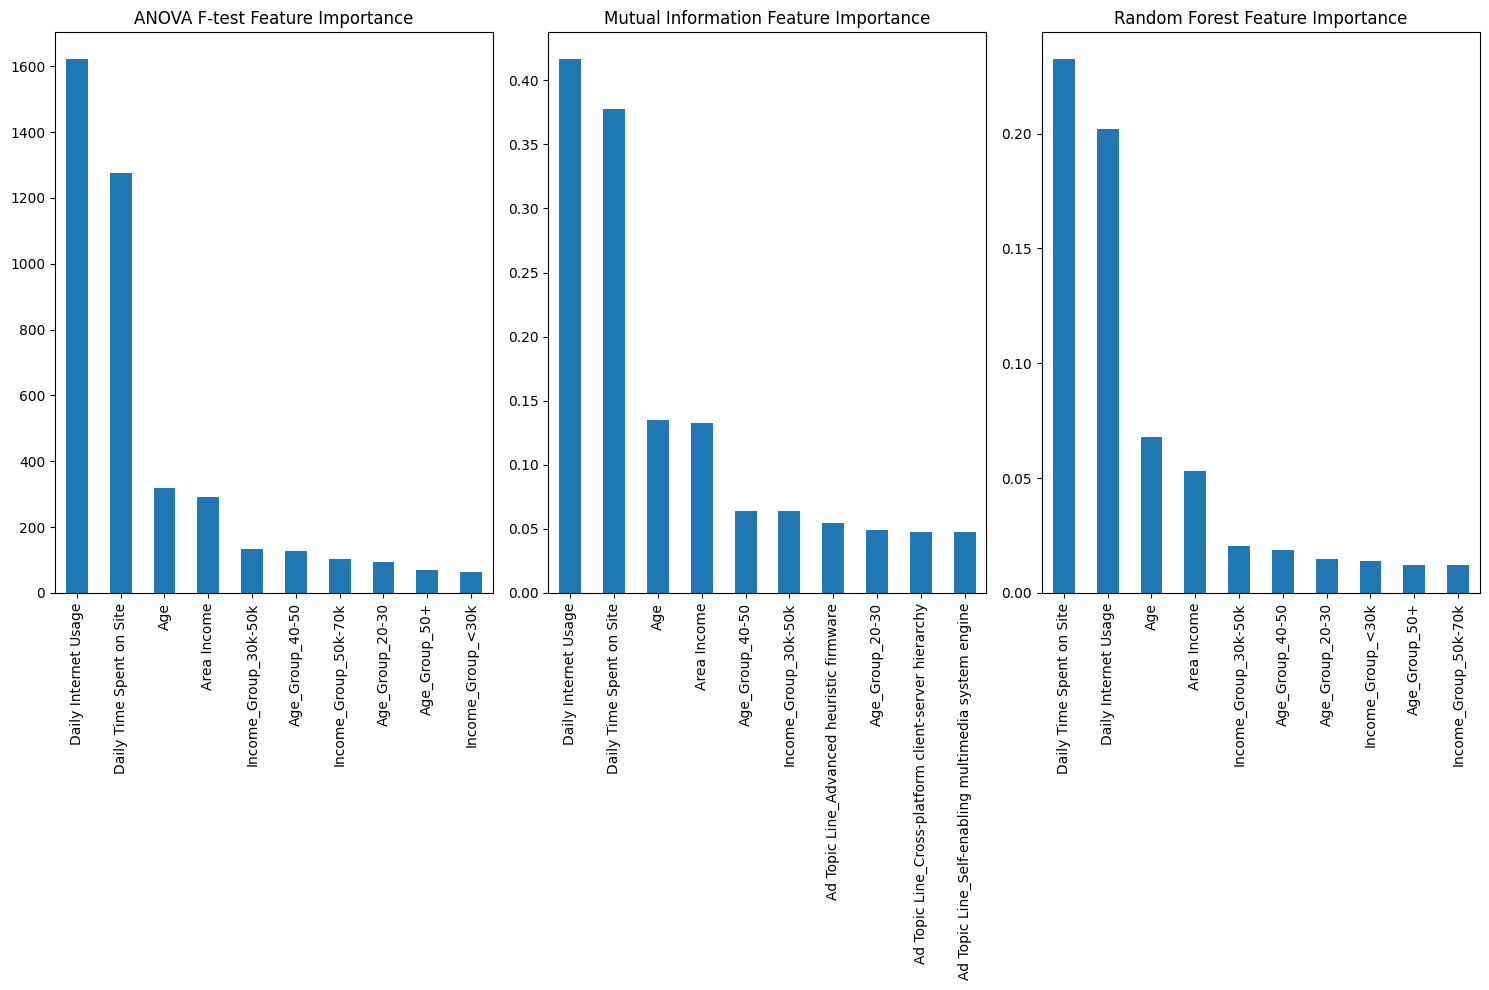


Top 10 Đặc trưng quan trọng (ANOVA F-test):
Daily Internet Usage        1622.093295
Daily Time Spent on Site    1274.310059
Age                          319.502179
Area Income                  290.280369
Income_Group_30k-50k         133.160210
Age_Group_40-50              125.866854
Income_Group_50k-70k         102.867441
Age_Group_20-30               94.547341
Age_Group_50+                 69.948634
Income_Group_<30k             64.496340
dtype: float64

Top 10 Đặc trưng quan trọng (Mutual Information):
Daily Internet Usage                                    0.416612
Daily Time Spent on Site                                0.377347
Age                                                     0.135207
Area Income                                             0.132804
Age_Group_40-50                                         0.064075
Income_Group_30k-50k                                    0.063917
Ad Topic Line_Advanced heuristic firmware               0.054790
Age_Group_20-30                   

In [42]:
# Phân tích đặc trưng quan trọng
def analyze_feature_importance(X, y):
    # Phương pháp ANOVA F-test
    f_scores, _ = f_classif(X, y)
    f_feature_importance = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)

    # Mutual Information
    mi_scores = mutual_info_classif(X_imputed, y)
    mi_feature_importance = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

    # Visualize đặc trưng quan trọng từ Random Forest
    rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Vẽ biểu đồ
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    f_feature_importance[:10].plot(kind='bar')
    plt.title('ANOVA F-test Feature Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()

    plt.subplot(1, 3, 2)
    mi_feature_importance[:10].plot(kind='bar')
    plt.title('Mutual Information Feature Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()

    plt.subplot(1, 3, 3)
    rf_importances[:10].plot(kind='bar')
    plt.title('Random Forest Feature Importance')
    plt.xticks(rotation=90)
    plt.tight_layout()

    plt.show()

    # In ra top 10 đặc trưng quan trọng
    print("\nTop 10 Đặc trưng quan trọng (ANOVA F-test):")
    print(f_feature_importance[:10])

    print("\nTop 10 Đặc trưng quan trọng (Mutual Information):")
    print(mi_feature_importance[:10])

    print("\nTop 10 Đặc trưng quan trọng (Random Forest):")
    print(rf_importances[:10])

X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)
analyze_feature_importance(X_imputed_df, y)

Nhận xét:
- Các thuộc tính quan trọng:

  - Daily Internet Usage (0.249) và Daily Time Spent on Site (0.226) là hai thuộc tính có tầm ảnh hưởng mạnh đến việc người dùng có click quảng cáo.
  - Area Income (0.090) và Age (0.079) cũng có ảnh hưởng nhưng ở mức thấp hơn.
- Thuộc tính ít quan trọng:
  - Các thuộc tính như Ad Topic Line, City có tầm quan trọng bằng 0, không đóng góp gì vào việc dự đoán. Do số lượng lớn các giá trị phân loại được chuyển đổi thành one-hot encoding.

## **Yêu cầu 8:** Đánh giá chất lượng mô hình sử dụng cross validation với các độ đo precision, recall, f1 trên tập train, test. Kết luận mô hình được lựa chọn

In [43]:
# Sử dụng cross-validation với StratifiedKFold
rf = RandomForestClassifier(random_state=42)
log_reg = LogisticRegression(random_state=42)
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

# Đánh giá Logistic Regression bằng cross-validation
log_reg_precision = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='precision')
rf_precision = cross_val_score(rf, X_train, y_train, cv=cv, scoring='precision')
log_reg_recall = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='recall')
log_reg_f1 = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='f1')

# Đánh giá Random Forest bằng cross-validation
rf_recall = cross_val_score(rf, X_train, y_train, cv=cv, scoring='recall')
rf_f1 = cross_val_score(rf, X_train, y_train, cv=cv, scoring='f1')

# Hiển thị kết quả
print("Logistic Regression (Precision, Recall, F1):")
print(f"Precision: {log_reg_precision.mean():.4f}, Recall: {log_reg_recall.mean():.4f}, F1: {log_reg_f1.mean():.4f}")

print("\nRandom Forest (Precision, Recall, F1):")
print(f"Precision: {rf_precision.mean():.4f}, Recall: {rf_recall.mean():.4f}, F1: {rf_f1.mean():.4f}")

d:\Others\LanguagePackets\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Others\LanguagePackets\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Logistic Regression (Precision, Recall, F1):
Precision: 0.9612, Recall: 0.8954, F1: 0.9254

Random Forest (Precision, Recall, F1):
Precision: 0.9677, Recall: 0.9516, F1: 0.9589


**<u>Nhận xét:</u>**

*   Cả hai mô hình có độ precision rất cao (trên 0.96), điều này cho thấy cả hai mô hình đều có khả năng dự đoán chính xác các đối tượng thuộc lớp mục tiêu.
*   Random Forest có độ recall cao hơn (0.9586 so với 0.9114 của Logistic Regression), nghĩa là mô hình Random Forest có khả năng phát hiện được nhiều đối tượng thuộc lớp mục tiêu hơn.
*   Random Forest có F1 cao hơn (0.9673 so với 0.9389 của Logistic Regression), chứng tỏ mô hình này có sự cân bằng tốt hơn giữa precision và recall.



In [44]:
# Huấn luyện mô hình trên tập huấn luyện
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Dự đoán trên cả tập train và test
log_reg_train_pred = log_reg.predict(X_train)
log_reg_test_pred = log_reg.predict(X_test)

rf_train_pred = rf.predict(X_train)
rf_test_pred = rf.predict(X_test)

# Đánh giá mô hình trên tập train và test
print("\nLogistic Regression - Train set evaluation:")
print(classification_report(y_train, log_reg_train_pred))

print("\nLogistic Regression - Test set evaluation:")
print(classification_report(y_test, log_reg_test_pred))

print("\nRandom Forest - Train set evaluation:")
print(classification_report(y_train, rf_train_pred))

print("\nRandom Forest - Test set evaluation:")
print(classification_report(y_test, rf_test_pred))

d:\Others\LanguagePackets\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression - Train set evaluation:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       405
           1       0.97      0.92      0.94       393

    accuracy                           0.94       798
   macro avg       0.94      0.94      0.94       798
weighted avg       0.94      0.94      0.94       798


Logistic Regression - Test set evaluation:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        95
           1       0.93      0.90      0.92       105

    accuracy                           0.92       200
   macro avg       0.91      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200


Random Forest - Train set evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       393

    accuracy                           1.00       798


**<u>Nhận xét và Kết luận:</u>**

1.   **<u>Logistic Regression:</u>**
    

  *   Precision, Recall, F1-score đều đạt 1.00 trên cả hai lớp (0 và 1), cho thấy mô hình đã học rất tốt trên tập Train và không có lỗi phân loại. Điều này cho thấy mô hình hoàn toàn chính xác trên dữ liệu huấn luyện.
  *   Mô hình đạt accuracy = 0.93 trên tập Test, với macro avg và weighted avg khoảng 0.93 - 0.94, cho thấy hiệu suất tổng thể khá tốt nhưng có sự mất cân bằng nhẹ giữa độ chính xác và khả năng phát hiện lớp 0 và lớp 1. Cụ thể:
*   Lớp 0 có precision cao (0.90) nhưng recall thấp (0.97), cho thấy mô hình ít bỏ sót các trường hợp lớp 0, nhưng đôi khi có thể đưa ra một số dự đoán sai.
*   Lớp 1 có recall thấp (0.90) mặc dù precision cao (0.97), điều này có thể chỉ ra rằng mô hình đôi khi không phát hiện được tất cả các trường hợp lớp 1.

2.   **<u>Random Forest:</u>**

*   Precision, Recall, F1-score đều đạt 1.00 trên cả hai lớp (0 và 1), giống như Logistic Regression, cho thấy mô hình học rất tốt trên tập Train và không có lỗi phân loại.
*   Mô hình đạt accuracy = 0.95 trên tập Test, với macro avg và weighted avg là 0.95, cho thấy mô hình hoạt động rất tốt trên tập Test và có sự cân bằng tốt hơn giữa độ chính xác và khả năng phát hiện các lớp.

3.   **<u>Kết luận:</u>**
Random Forest là mô hình được lựa chọn trong trường hợp này vì có hiệu suất tổng thể tốt hơn trên tập kiểm tra với độ chính xác cao hơn (95% so với 93%) và cân bằng tốt hơn giữa precision và recall. Mô hình này có khả năng phát hiện đầy đủ hơn các đối tượng thuộc lớp mục tiêu mà không bỏ sót quá nhiều, đồng thời vẫn giữ được độ chính xác cao.
